Welcome, today date is March 11, 2023 at: 19H27
This Application is to display information on hospital data relating to the COVID-19 epidemic in France.
Please enter the French department: paris
https://data.opendatasoft.com/api/records/1.0/search/?dataset=donnees-hospitalieres-covid-19-dep-france%40public&q=&rows=10000&sort=-date&facet=date&facet=countrycode_iso_3166_1_alpha3&facet=region_min&facet=nom_dep_min&facet=sex&refine.sex=Tous&refine.nom_dep_min=Paris
You have chosen the Paris department and it exists !!!
     months  hospDay  intcare  dayOut  death
0   2020Mar     3075      716     708    350
1   2020Apr     5031     1091    3535   1125
2   2020May      802      213    1666    240
3   2020Jun      163       40     421     56
4   2020Jul      175       43     413     27
5   2020Aug      258       59     215     31
6   2020Sep      843      203     617     71
7   2020Oct     2176      481    1161    213
8   2020Nov     2099      528    1740    398
9   2020Dec     1169      252

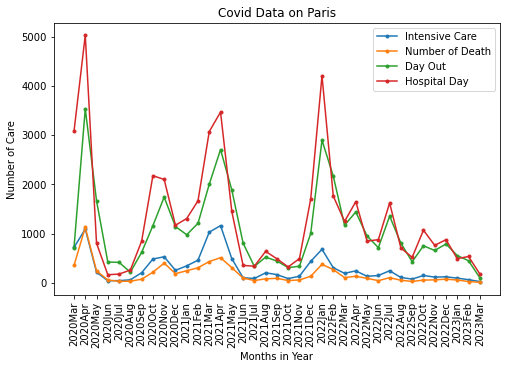

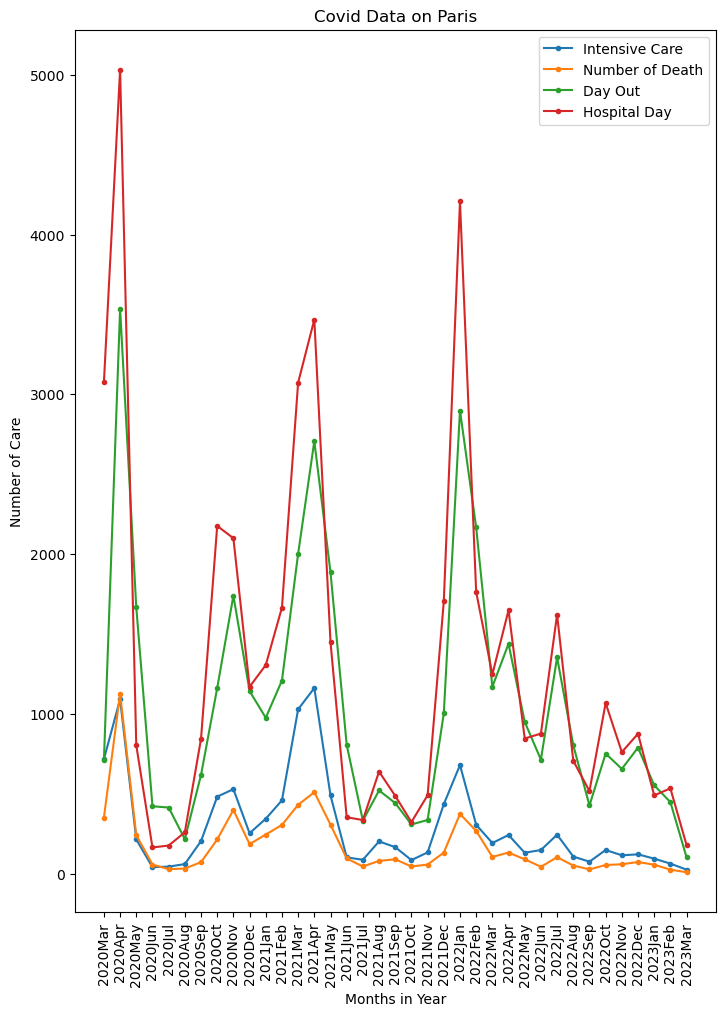

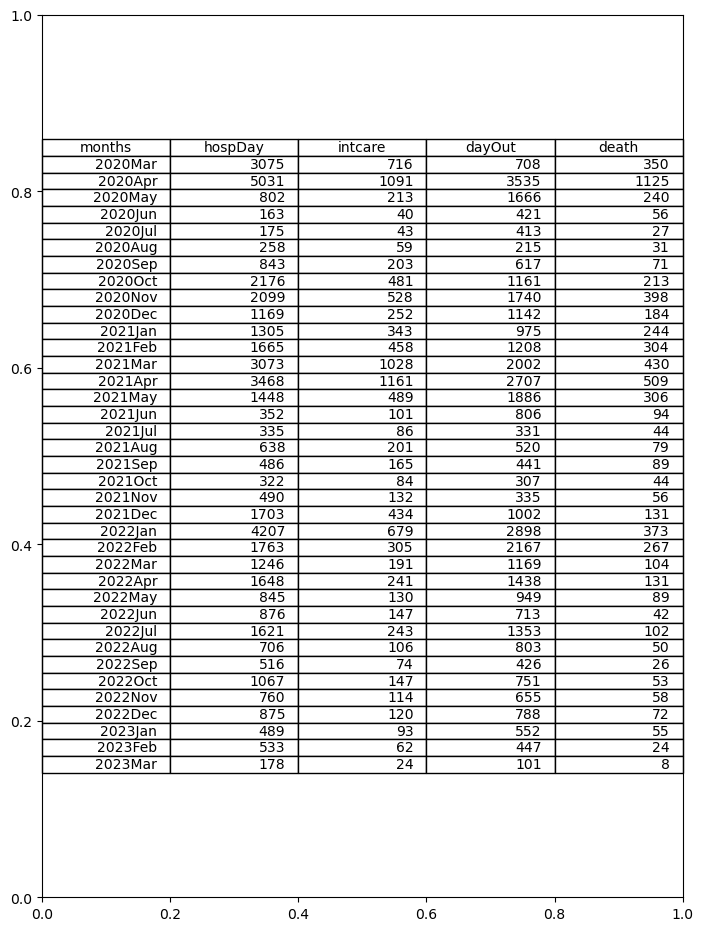

In [1]:
import datetime
import requests
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from flask import Flask


# Class set to make a text bold or underlined


app = Flask(__name__)

class makeBold:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'


# This is to create current date and time
today = datetime.today()
now = today.strftime("%B %d, %Y")
getTime = datetime.now()
time = getTime.strftime("%HH%M")

print('Welcome, today date is', now, 'at:', time)
print('This Application is to display information on hospital data relating to the COVID-19 epidemic in France.')

# Get the user input on the department
dept = input('Please enter the French department: ')
dept = dept.capitalize()

# The Json request is done here
# url = https://data.opendatasoft.com/api/records/1.0/search/?dataset=donnees-hospitalieres-covid-19-dep-france%40public&q=&facet=date&facet=countrycode_iso_3166_1_alpha3&facet=region_min&facet=nom_dep_min&facet=sex&refine.sex=Tous&refine.nom_dep_min=Calvados
cUrl = "https://data.opendatasoft.com/api/records/1.0/search/?dataset=donnees-hospitalieres-covid-19-dep-france%40public&q=&rows=10000&sort=-date&facet=date&facet=countrycode_iso_3166_1_alpha3&facet=region_min&facet=nom_dep_min&facet=sex&refine.sex=Tous&refine.nom_dep_min=" + dept
print(cUrl)
covidData = requests.get(cUrl)

# Convert the request gotton from covidData to Json format
jsonData = covidData.json()

# Write to file using the converted Json format variable
with open('data.json', 'w') as outfile:
    importData = json.dump(jsonData, outfile, indent=4)

if jsonData["nhits"] == 0:
    print('There is no department called:', dept)
else:
    print('You have chosen the', (makeBold.BOLD + dept +
          makeBold.END), 'department and it exists !!!')


# keys will ymonths (e.g. "2020-10") and values will be accumulation of newintcare
month = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
          7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
total = {}


# Get to display the number of intensive care per month
for care in jsonData['records']:
    date = care['fields']['date']
    if "day_intcare_new" in care['fields']:
        intcare = care['fields']['day_intcare_new']
    else:
        intcare = 0

    # ymonth = date[0:7]
    year = date[0:4]
    monthlist = int(date[5:7])
    mon = month[monthlist]
    yearMonth = year + mon

    #print(yearMonth)

    death = 0
    hospDay = 0
    dayOut = 0

    if "day_hosp_new" in care['fields']:
        hospDay = care['fields']['day_hosp_new']
    else:
        hospDay = 0

    if 'day_out_new' in care['fields']:
        dayOut = care['fields']['day_out_new']
    else:
        dayOut = 0

    if 'day_death_new' in care['fields']:
        death = care['fields']['day_death_new']
    else:
        death = 0

    if yearMonth in total:

        total[yearMonth]['hospDay'] = total[yearMonth]['hospDay'] + hospDay
        total[yearMonth]['intcare'] = total[yearMonth]['intcare'] + intcare
        total[yearMonth]['dayOut'] = total[yearMonth]['dayOut'] + dayOut
        total[yearMonth]['death'] = total[yearMonth]['death'] + death

    else:
        total[yearMonth] = {
                'hospDay': hospDay,
                'intcare': intcare,
                'dayOut': dayOut,
                'death': death,
        }


df1 = (pd.DataFrame(total)).T
df1.reset_index(inplace=True)
df1new = df1.rename(columns={'index': 'months'})
print(df1new)



toCSV = df1new.to_csv('Covid_data.csv', encoding='utf-8')

readCSV = pd.read_csv('Covid_data.csv')



# MatPlotLib
plt.figure(figsize=(8,5))
plt.title('Covid Data on ' + dept)
plt.plot(readCSV.months, readCSV.intcare, '.-', label = "Intensive Care")
plt.plot(readCSV.months, readCSV.death, '.-', label = "Number of Death")
plt.plot(readCSV.months, readCSV.dayOut, '.-', label = "Day Out")
plt.plot(readCSV.months, readCSV.hospDay, '.-', label = "Hospital Day")
plt.ylabel('Number of Care')
plt.xlabel('Months in Year')
plt.xticks(rotation=90)
plt.legend()
plt.savefig("imageplot.png")
plt.show()



pdf_pages = PdfPages('Covid19_Data.pdf')
 
for i in range(1):
  # Create a figure instance (ie. a new page)
  fig = plt.figure(figsize=(8.27, 11.69), dpi=100)
    
 
  # Plot whatever you wish to plot
  plt.title('Covid Data on ' + dept)
  plt.plot(readCSV.months, readCSV.intcare, '.-', label = "Intensive Care")
  plt.plot(readCSV.months, readCSV.death, '.-', label = "Number of Death")
  plt.plot(readCSV.months, readCSV.dayOut, '.-', label = "Day Out")
  plt.plot(readCSV.months, readCSV.hospDay, '.-', label = "Hospital Day")
  plt.ylabel('Number of Care')
  plt.xlabel('Months in Year')
  plt.xticks(rotation=90)
  #plt.table(cellText=df1new.values, colLabels=df1new.columns, loc='top')
  plt.legend()
  plt.show()
    
 
  # Done with the page
  pdf_pages.savefig(fig)

for i in range(1):
    
    figs = plt.figure(figsize=(8.27, 11.69), dpi=100)
    plt.table(cellText=df1new.values, colLabels=df1new.columns, loc='center')
    pdf_pages.savefig(figs)
    
# Write the PDF document to the disk
pdf_pages.close()


web_display = df1new.to_html()


# Write html to file
text_file = open("index.html", "w")
text_file.write(web_display)
text_file.close()

